In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 3. Post-processing algorithms to achieve fairness

In [2]:
from scipy.optimize import linprog

In [3]:
class Postprocessing_equalized_odds():
    """Solves a linear program to find probabilities with which to change output
    labels to optimize equalized odds.

    References:
         M. Hardt, E. Price, and N. Srebro, "Equality of Opportunity in
         Supervised Learning," Conference on Neural Information Processing
         Systems, 2016.
    """

    def __init__(self):
        self.parameters = None


    def fit(self, predicted_labels, true_labels, sensetive_attribute):
        """This function computes the parameters for equalized odds predicted
        labels, true labels and the sensetive attribute.

      Input:
      predicted_labels: nx1 array with the labels predicted by a binary classifier
      true_labels: nx1 array with the actual labels of the data
      sensetive_attribute:  nx1 array where 1 indicates membership in Group A and
                        0 indicates a membership in Group B

        Output:
            No output
        """


        # linear program has four variables:
        # p00 =  Pr[new_label = 1 | old_label = 1, sensetive_attribute = 0];
        # p01 =  Pr[new_label = 1 | old_label = 0, sensetive_attribute = 0];
        # p10 =  Pr[new_label = 1 | old_label = 1, sensetive_attribute = 1];
        # p11 =  Pr[new_label = 1 | old_label = 0, sensetive_attribute = 1]]

        # Coefficients of the objective function
        ####
        ###
        ##TODO
        sensitive_attribute = sensetive_attribute
        grp_0 = np.where(sensitive_attribute == 0)
        grp_1 = np.where(sensitive_attribute == 1)

        y_0 = np.where(true_labels == 0)
        y_1 = np.where(true_labels == 1)

        idx_00 = np.intersect1d( y_0, grp_0)
        idx_01 = np.intersect1d( y_0, grp_1)
        idx_10 = np.intersect1d( y_1, grp_0)
        idx_11 = np.intersect1d( y_1, grp_1)

        g_0 = len(grp_0[0]) / len(sensitive_attribute)
        g_1 = (1 - g_0)

        # y_00 means P[Y=0 | A=0]
        y_00 = len(true_labels[np.where(true_labels[grp_0] == 0)]) / len(grp_0[0])
        y_01 = len(true_labels[np.where(true_labels[grp_1] == 0)]) / len(grp_1[0])
        y_10 = (1 - y_00)
        y_11 = (1 - y_01)

        #p_0_00 means P[predicted_label = 1 | true_label = 0, sensitive_attr = 0]
        p_0_00 = len(predicted_labels[np.where(predicted_labels[idx_00] == 0)]) / len(idx_00)
        p_0_01 = len(predicted_labels[np.where(predicted_labels[idx_01] == 0)]) / len(idx_01)
        p_0_10 = len(predicted_labels[np.where(predicted_labels[idx_10] == 0)]) / len(idx_10)
        p_0_11 = len(predicted_labels[np.where(predicted_labels[idx_11] == 0)]) / len(idx_11)

        p_1_00 = (1 - p_0_00)
        p_1_01 = (1 - p_0_01)
        p_1_10 = (1 - p_0_10)
        p_1_11 = (1 - p_0_11)

        c_00 = g_0*(p_0_10*y_10 - p_0_00*y_00)
        c_01 = g_1*(p_0_11*y_11 - p_0_01*y_01)
        c_10 = g_0*(p_1_10*y_10 - p_1_00*y_00)
        c_11 = g_1*(p_1_11*y_11 - p_1_01*y_01)

        c = np.array([-c_00, -c_01, -c_10, -c_11])

        ####
        p00_bounds = (0,1)
        p01_bounds = (0,1)
        p10_bounds = (0,1)
        p11_bounds = (0,1)

        ##TODO

        A_eq = [[p_0_00,
                 -p_0_01,
                 p_1_00,
                 -p_1_01],
                [p_0_10,
                 -p_0_11,
                 p_1_10,
                 -p_1_11]]


        b_eq = [0,0]
        ####

        res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[p00_bounds, p01_bounds,
                                                 p10_bounds, p11_bounds])
        parameters = res.x
        parameters[parameters >=1] = 1
        parameters[parameters <=0] = 0
        self.parameters = parameters

    def predict(self, predicted_labels, sensetive_attribute):
        p00, p01, p10, p11  = self.parameters
        new_labels = np.zeros_like(predicted_labels)

        sensitive_attribute = sensetive_attribute

        ### TODO ##
        p_select = {"00": p00, "01": p01, "10": p10, "11": p11}
        for i in range(len(predicted_labels)):
          pr = p_select[f"{int(predicted_labels[i])}{int(sensitive_attribute[i])}"]
          new_labels[i] = np.random.choice([0, 1], p=[(1 - pr), pr])
        ##
        return new_labels

## 4. Equalized odds classifier

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import LabelEncoder

In [5]:
adult = fetch_openml(name='adult', version=1, parser='auto')
x_full = adult.data
y_full  = 1 * (adult.target == ">50K")
x_full = x_full.dropna()
y_full = y_full.loc[x_full.index]
features = adult.feature_names
le = LabelEncoder()
for feature in features:
    if x_full[feature].dtype == 'category':
        le.fit(x_full[feature])
        x_full.loc[:,feature] = le.transform(x_full[feature])
x_train, x_test, y_train, y_test = train_test_split(x_full.to_numpy(), y_full.to_numpy(), test_size=0.33, random_state=42)

<ipython-input-5-d3e1210e96f6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_full.loc[:,feature] = le.transform(x_full[feature])
<ipython-input-5-d3e1210e96f6>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_full.loc[:,feature] = le.transform(x_full[feature])
<ipython-input-5-d3e1210e96f6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [14]:
clf = DecisionTreeClassifier(random_state=0, max_depth=2)

In [15]:
# Train the classifier as before
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [16]:
#Use the equalized_odds function from the previous task
def equalized_odds(predicted_labels, true_labels, sensetive_attribute ):
  '''
  This function calculates how far a binary classifier is from achieving equalized odds.
  Input:
  predicted_labels: nx1 array with the labels predicted by a binary classifier
  true_labels: nx1 array with the actual labels of the data
  sensetive_attribute:  nx1 array where 1 indicates membership in Group A and
                        0 indicates a membership in Group B
  Output: Float between -1 and 1
  '''
  group_a = np.where(sensetive_attribute == 1)[0]
  group_b = np.where(sensetive_attribute == 0)[0]

  class_0 = np.where(true_labels == 0)[0]
  class_1 = np.where(true_labels == 1)[0]

  idx_a0 = np.intersect1d(group_a, class_0)
  idx_a1 = np.intersect1d(group_a, class_1)
  idx_b0 = np.intersect1d(group_b, class_0)
  idx_b1 = np.intersect1d(group_b, class_1)

  # f(x) = 1 | x = {A, B}, y = {0,1}
  count_a_class_0 = len(np.where(predicted_labels[idx_a0] == 1)[0])
  count_b_class_0 = len(np.where(predicted_labels[idx_b0] == 1)[0])
  count_a_class_1 = len(np.where(predicted_labels[idx_a1] == 1)[0])
  count_b_class_1 = len(np.where(predicted_labels[idx_b1] == 1)[0])

  prob_a0 = count_a_class_0 / len(idx_a0)
  prob_b0 = count_b_class_0 / len(idx_b0)
  prob_a1 = count_a_class_1 / len(idx_a1)
  prob_b1 = count_b_class_1 / len(idx_b1)

  return max(abs(prob_a0 - prob_b0), abs(prob_a1 - prob_b1))

  return None

In [17]:
predictions_train = clf.predict(x_train)
predictions_test = clf.predict(x_test)

In [18]:
post_process = Postprocessing_equalized_odds()
post_process.fit(predictions_train, y_train, x_train[:,9])

In [19]:
## The training accuracy of the new classifier
predictions_post_train = post_process.predict(predictions_train, x_train[:,9])
(post_process.predict(predictions_post_train, x_train[:,9]) == y_train).mean()

0.7537131163773186

In [20]:
## The test accuracy of the new classifier
predictions_post_test = post_process.predict(predictions_test, x_test[:,9])
(predictions_post_test == y_test).mean()

0.778678638434736

In [21]:
print(equalized_odds(predictions_train, y_train, x_train[:,9] ))
print(equalized_odds(predictions_post_train, y_train, x_train[:,9] ) )
print(equalized_odds(predictions_test, y_test, x_test[:,9] ))
print(equalized_odds(predictions_post_test, y_test, x_test[:,9] ) )

0.2978416998573178
0.0073163238150829035
0.26066247805599185
0.03441051464473807


## 5. Relaxed equalized odds

In [22]:
class Postprocessing_relaxed_equalized_odds():
    """Solves a linear program to find probabilities with which to change output
    labels to optimize relaxed equalized odds.

    References:
         M. Hardt, E. Price, and N. Srebro, "Equality of Opportunity in
         Supervised Learning," Conference on Neural Information Processing
         Systems, 2016.
    """

    def __init__(self,lamda):
        self.parameters = None
        self.lamda = lamda


    def fit(self, predicted_labels, true_labels, sensetive_attribute):
        """This function computes the parameters for equalized odds predicted
        labels, true labels and the sensetive attribute.

      Input:
      predicted_labels: nx1 array with the labels predicted by a binary classifier
      true_labels: nx1 array with the actual labels of the data
      sensetive_attribute:  nx1 array where 1 indicates membership in Group A and
                        0 indicates a membership in Group B

        Output:
            No output
        """


       # linear program has four variables:
        # p00 =  Pr[new_label = 1 | old_label = 1, sensetive_attribute = 0];
        # p01 =  Pr[new_label = 1 | old_label = 0, sensetive_attribute = 0];
        # p10 =  Pr[new_label = 1 | old_label = 1, sensetive_attribute = 1];
        # p11 =  Pr[new_label = 1 | old_label = 0, sensetive_attribute = 1]]

        # Coefficients of the objective function
        ####
        sensitive_attribute = sensetive_attribute
        ##TODO
        grp_0 = np.where(sensitive_attribute == 0)
        grp_1 = np.where(sensitive_attribute == 1)

        y_0 = np.where(true_labels == 0)
        y_1 = np.where(true_labels == 1)

        idx_00 = np.intersect1d( y_0, grp_0)
        idx_01 = np.intersect1d( y_0, grp_1)
        idx_10 = np.intersect1d( y_1, grp_0)
        idx_11 = np.intersect1d( y_1, grp_1)

        g_0 = len(grp_0[0]) / len(sensitive_attribute)
        g_1 = (1 - g_0)

        # y_00 means P[Y=0 | A=0]
        y_00 = len(true_labels[np.where(true_labels[grp_0] == 0)]) / len(grp_0[0])
        y_01 = len(true_labels[np.where(true_labels[grp_1] == 0)]) / len(grp_1[0])
        y_10 = (1 - y_00)
        y_11 = (1 - y_01)

        #p_0_00 means P[predicted_label = 1 | true_label = 0, sensitive_attr = 0]
        p_0_00 = len(predicted_labels[np.where(predicted_labels[idx_00] == 0)]) / len(idx_00)
        p_0_01 = len(predicted_labels[np.where(predicted_labels[idx_01] == 0)]) / len(idx_01)
        p_0_10 = len(predicted_labels[np.where(predicted_labels[idx_10] == 0)]) / len(idx_10)
        p_0_11 = len(predicted_labels[np.where(predicted_labels[idx_11] == 0)]) / len(idx_11)

        p_1_00 = (1 - p_0_00)
        p_1_01 = (1 - p_0_01)
        p_1_10 = (1 - p_0_10)
        p_1_11 = (1 - p_0_11)


        c_00 = g_0*(p_0_10*y_10 - p_0_00*y_00)
        c_01 = g_1*(p_0_11*y_11 - p_0_01*y_01)
        c_10 = g_0*(p_1_10*y_10 - p_1_00*y_00)
        c_11 = g_1*(p_1_11*y_11 - p_1_01*y_01)

        c = np.array([-c_00, -c_01, -c_10, -c_11])

        ####
        p00_bounds = (0,1)
        p01_bounds = (0,1)
        p10_bounds = (0,1)
        p11_bounds = (0,1)

        ##TODO

        A_ub = [[p_0_00,
                 -p_0_01,
                 p_1_00,
                 -p_1_01],
                [p_0_10,
                 -p_0_11,
                 p_1_10,
                 -p_1_11],
                [-p_0_10,
                 p_0_11,
                 -p_1_10,
                 p_1_11],
                 [-p_0_10,
                 p_0_11,
                 -p_1_10,
                 p_1_11]]

        b_ub = [self.lamda, self.lamda, self.lamda, self.lamda]
        ####

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=[p00_bounds, p01_bounds,
                                                 p10_bounds, p11_bounds])
        parameters = res.x
        parameters[parameters >=1] = 1
        parameters[parameters <=0] = 0
        self.parameters = parameters


    def predict(self, predicted_labels, sensetive_attribute):
        p00, p01, p10, p11  = self.parameters
        new_labels = np.zeros_like(predicted_labels)

        sensitive_attribute = sensetive_attribute

        ### TODO ##
        p_select = {"00": p00, "01": p01, "10": p10, "11": p11}
        for i in range(len(predicted_labels)):
          pr = p_select[f"{int(predicted_labels[i])}{int(sensitive_attribute[i])}"]
          new_labels[i] = np.random.choice([0, 1], p=[(1 - pr), pr])
        ##
        return new_labels

In [23]:
lamdas = np.arange(11)/100
train_accs, test_accs = np.zeros_like(lamdas), np.zeros_like(lamdas)
train_equs, test_equs = np.zeros_like(lamdas), np.zeros_like(lamdas)
for i, lamda in enumerate(lamdas) :
  post_process = Postprocessing_relaxed_equalized_odds(lamda=lamda)
  post_process.fit(predictions_train, y_train, x_train[:,9])
  predictions_post_train = post_process.predict(predictions_train, x_train[:,9])
  train_accs[i] = (predictions_post_train == y_train).mean()
  predictions_post_test = post_process.predict(predictions_test, x_test[:,9])
  test_accs[i] = (predictions_post_test == y_test).mean()
  train_equs[i] = equalized_odds(predictions_post_train, y_train, x_train[:,9] )
  test_equs[i] = equalized_odds(predictions_post_test, y_test, x_test[:,9] )

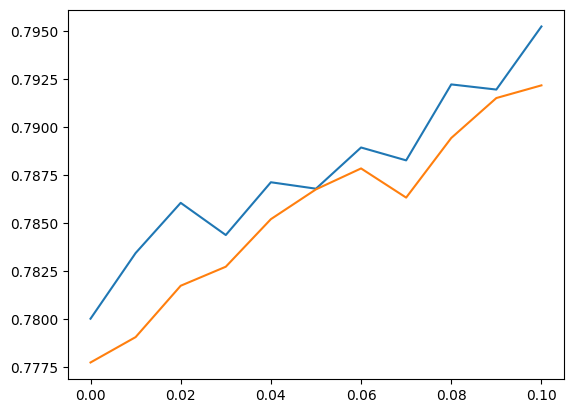

In [24]:
plt.plot(lamdas, test_accs)
plt.plot(lamdas, train_accs)

In [26]:
test_accs

array([0.78001876, 0.78343608, 0.78604932, 0.78437416, 0.78712142,
       0.78678638, 0.78893058, 0.78826052, 0.79221388, 0.79194586,
       0.79522916])

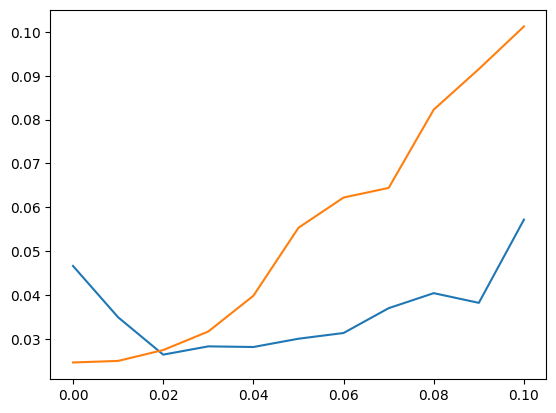

In [25]:
plt.plot(lamdas, test_equs)
plt.plot(lamdas, train_equs)